Assignment 2: 

Name: Nisargkumar Upadhyay

UID: 118221625

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 


In [54]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
import random
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 216MB/s]
Archive:  /content/part1_images.zip
   creating: /content/part1_images/
  inflating: /content/part1_images/hotel.seq41.png  
  inflating: /content/part1_images/hotel.seq40.png  
  inflating: /content/part1_images/hotel.seq42.png  
  inflating: /content/part1_images/hotel.seq43.png  
  inflating: /content/part1_images/hotel.seq47.png  
  inflating: /content/part1_images/hotel.seq46.png  
  inflating: /content/part1_images/hotel.seq50.png  
  inflating: /content/part1_images/hotel.seq44.png  
  inflating: /content/part1_images/hotel.seq8.png  
  inflating: /content/part1_images/hotel.seq9.png  
  inflating: /content/part1_images/hotel.seq45.png  
  inflating: /content/part1_images/hotel.seq36.png  
  inflating: /content/part1_images/hotel.seq22.png  
  inflating: /content/part1_images/hotel.seq23.png  
  inflating: /content/part1_imag

## Helper Functions

In [55]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return arr_images

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)     
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):
    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)

  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51)



## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

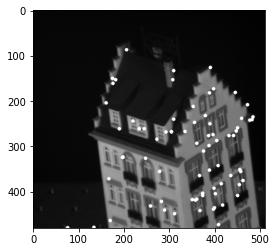

In [56]:
# Function to get the conner points
def getKeypoints(img,T):
  conner_points = []

  # Gaussian blur function
  def gaussian_2D_filter(shape,sigma):
    M = shape[0]
    N = shape[1]
    H = np.zeros((M, N), np.float32)
    D0 = sigma
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = np.exp(-D**2/(2*D0*D0))
    return H
  x = np.shape(img)
  sigma = 0.4
  filter = gaussian_2D_filter(x, sigma)

  img_blur = cv2.filter2D(img, -1, filter, borderType=cv2.BORDER_CONSTANT)
  
  gaussian_kernel = np.array([[1/16, 1/8, 1/16],  
                              [1/8, 1/4, 1/8],
                              [1/16, 1/8, 1/16]])

  # obtaing the derivative and dividing the kernal into 2 parts
  gaussian_derivative_x = gaussian_kernel*[1,0,-1]
  gaussian_derivative_y = (gaussian_derivative_x.T)
  I_y = cv2.filter2D(img_blur, -1, gaussian_derivative_y, borderType=cv2.BORDER_CONSTANT)
  I_x = cv2.filter2D(img_blur, -1, gaussian_derivative_x, borderType=cv2.BORDER_CONSTANT)

  # Second Moment Matrix coordinates
  Ixx = ndimage.gaussian_filter(I_x**2, sigma=1)
  Ixy = ndimage.gaussian_filter(I_y*I_x, sigma=1)
  Iyy = ndimage.gaussian_filter(I_y**2, sigma=1)

  k = 0.3
  # determinant
  detA = Ixx * Iyy - Ixy ** 2
  # trace
  traceA = Ixx + Iyy

  # Harris conner Points  
  harris_response = detA - k * traceA ** 2
  cv2.normalize(harris_response, harris_response, 0, 1, cv2.NORM_MINMAX)
  conner = np.where(harris_response >=T ) #Non max Supression

  for pt in zip(*conner[::-1]):
    conner_points.append(pt)

  x = conner_points # All the conner points
  return x

folder = '/content/part1_images/'
im = readImages(folder, 51)
im =cv2.cvtColor(im[33], cv2.COLOR_BGR2GRAY)
key_pts = getKeypoints(im,1) #conner Points

# Display of all the conner points
for i in key_pts:
  cv2.circle(im,i, 1, (255,0,0), 5)
plt.imshow(im, cmap = 'gray')


### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()


1) Convert Color image to grayscale and smooth it

2) Create a Gaussian filter and took its deivative, divided it into x and y parts and then perform a convolution over the images

3) Create Ixx,Iyy,Ixy. These are the variables of the second moment matrix

4) Harris response calculation by taking the determinent and trace of the second moment matrix

5) Perform Non-maximum suppression that will discard the extra points and give us the conner points

*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)

I displayed the image in the grayscale with white dots as the conner points



**Include your write-up here**

A-1) 

## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

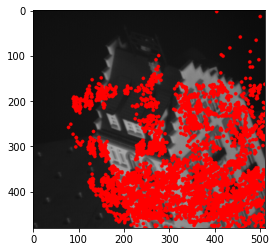

In [57]:
new_points = []
def LK_OpticalFlow(features,Image1,Image2,w):
  I1 = np.array(Image1)
  I2 = np.array(Image2)
  S = np.shape(I1)

    #applying Gaussian filter of size 3x3 to eliminate any noise
  I1_smooth = cv2.GaussianBlur(I1,(5,5),0)
  I2_smooth = cv2.GaussianBlur(I2,(5,5),0)

  gaussian_kernel = np.array([[1/16, 1/8, 1/16],  
                              [1/8, 1/4, 1/8],
                              [1/16, 1/8, 1/16]])

  # obtaing the derivative and dividing the kernal into 2 parts
  gaussian_derivative_x = gaussian_kernel*[1,0,-1]
  gaussian_derivative_y = (gaussian_derivative_x.T)

  dy1 = cv2.filter2D(I1_smooth, -1, gaussian_derivative_y, borderType=cv2.BORDER_CONSTANT)
  dx1 = cv2.filter2D(I1_smooth, -1, gaussian_derivative_x, borderType=cv2.BORDER_CONSTANT)
  dy2 = cv2.filter2D(I2_smooth, -1, gaussian_derivative_y, borderType=cv2.BORDER_CONSTANT)
  dx2 = cv2.filter2D(I2_smooth, -1, gaussian_derivative_x, borderType=cv2.BORDER_CONSTANT)

  fx = (dx1+dx2)
  fy = (dy1+dy2)
  ft = I2 - I1

  features = np.int0(features)
  u = np.zeros(I1_smooth.shape)
  v = np.zeros(I1_smooth.shape)

  for feature in features:        
          j, i = feature.ravel()
          i, j = int(i), int(j)
            
          # Coordinates of the second moment matrix
          I_x = fx[i-w:i+w+1, j-w:j+w+1].flatten()
          I_y = fy[i-w:i+w+1, j-w:j+w+1].flatten()
          I_t = ft[i-w:i+w+1, j-w:j+w+1].flatten()

          b = np.reshape(I_t, (I_t.shape[0],1))
          A = np.vstack((I_x, I_y)).T

          U = np.matmul(np.linalg.pinv(A), b) 
              # Solving for (u,v) i.e., U

          a = U[0][0]
          b = U[1][0]
          x = a+i
          y = b+j

          newPoint = [x,y]

          new_points.append(newPoint) 

  new_p = np.array(new_points) 


   
  return  new_p 


#import the images
z = cv2.imread("/content/part1_images/hotel.seq0.png")
z1 = cv2.imread("/content/part1_images/hotel.seq0.png")

for j in range(50):
  img_1 = cv2.imread(f'/content/part1_images/hotel.seq{j}.png')
  img_2 = cv2.imread(f'/content/part1_images/hotel.seq{j+1}.png')
  image_1 =cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
  image_2 =cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
  features = getKeypoints(image_1,1) # Thersold  = 1

  new_p = LK_OpticalFlow(features,image_1,image_2,7)

  for i in new_p:
    i = np.array(i)
    center = (int(i[0]),int(i[1]))


    z =  cv2.circle(z,center, 1, (255,0,0), 5)
plt.imshow(z,cmap = 'gray')



### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [24]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 65.7MB/s]
Archive:  /content/part2_images.zip
replace /content/part2_images/Bone_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Helper Functions

In [28]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

## Code (15 pts)

In [51]:
import cv2
import numpy as np

# A function to perfom an SVD operation
def calculate_F_matrix(list_kp1, list_kp2):

    A = np.zeros(shape=(len(list_kp1), 9))
    
    for i in range(len(list_kp1)):
        x1, y1 = list_kp1[i][0], list_kp1[i][1]
        x2, y2 = list_kp2[i][0], list_kp2[i][1]
        A[i] = np.array([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])

    U, S, VT = np.linalg.svd(A)
    F = VT[-1,:]
    F = F.reshape(3,3)
    u, s, vt = np.linalg.svd(F)
    s[-1] = 0
    S = np.zeros((3,3))
    for i in range(3):
        S[i][i] = s[i]

    F = np.dot(u, np.dot(S, vt))
    return F

# Function to perform the Ransac Operation
def RANSAC_F_matrix(x_a,x_b):
    S_in = []
    points = 8
    n = 0
    epsilon = .005
    max_pts = 1000
    iterations = 20
    Best_F = None

    for i in range(iterations):
        x1,x2 = [],[]
        mask = []

        for j in range(points):
            k = random.randint(0,len(x_a)-1)
            x1.append(x_a[k])
            x2.append(x_b[k])
        F = calculate_F_matrix(x1,x2)

        S = []
        for p1,p2 in zip(x_a,x_b):
            x1j = np.array([p1[0],p1[1],1])
            x2j = np.array([p2[0],p2[1],1])
            val = abs(x2j.T @ F @ x1j)
            if val < epsilon:
                S.append([p1,p2])
                mask.append(1)
            else:
                mask.append(0)
        if len(S) > n:
            n = len(S)
            S_in = S
            Best_F = F
            best_mask = mask
    return Best_F 


img1 = cv2.imread("/content/part2_images/bird_1.png")
img2 = cv2.imread("/content/part2_images/bird_2.png")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

pts1 = getKeypoints(img1_gray,1)
pts2 = LK_OpticalFlow(pts1,img1_gray,img2_gray,7)
transformation_matrix= RANSAC_F_matrix(pts1,pts2)
print(transformation_matrix)

[[ 4.49022027e-06 -1.51432741e-06  2.19126815e-04]
 [ 7.71690185e-06  2.28361857e-05 -6.97055917e-03]
 [ 1.35503017e-03 -3.69030798e-03  9.99967954e-01]]


In [ ]:
imgPath = '/content/part2_images/';

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', \
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', \
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', \
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

# Add code to run align_shape() and display the results and the errors
# YOUR CODE HERE

## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

I have took all the points and performed a SVD operation 
then i passed that into RANSAC function which provided me the best transormation Matrix


2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Include your write-up here**

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [33]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 97.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 95.5MB/s]


## Code (10 pts)

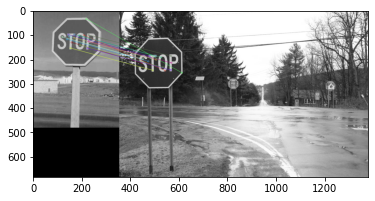

In [53]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Function for the sift points and the descriptors 
def sift_detector(imgA, imgB):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgA, None) 
    kp2, des2 = sift.detectAndCompute(imgB, None)
    bf = cv2.BFMatcher()

    # Finding the best points based on nearest neignbour
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    best_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)
            best_matches.append([m])

    feature_1 = []
    feature_2 = []

    for i, match in enumerate(good):
        feature_1.append(kp1[match.queryIdx].pt)
        feature_2.append(kp2[match.trainIdx].pt)
    return feature_1, feature_2, kp1, kp2, best_matches
MIN_MATCH_COUNT = 10
img1 = cv2.imread("/content/stop1.jpg")
img2 = cv2.imread("/content/stop2.jpg")
img1 =cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 =cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT


feature_1, feature_2, kp1, kp2, best_matches = sift_detector(img1, img2)
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, best_matches, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,cmap = 'gray')

## Write-up (10 pts)


(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Your answer here**
For this i have used nearest neignbour  approch based on the thresold.
I have displayed the result based on the thresold 0.5
if i incresed the thresold it will detetct all the unnecessary surrounding objects